# Network Training
Having implemented and tested all the components of the final networks in steps 1-3, we are now ready to train the network on a large dataset (ImageNet).

In [1]:
import gc
import datetime

import pandas as pd
import numpy as np

from copy import deepcopy
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras import backend as K

import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import clear_output

from libs.pconv_model import PConvUnet
from libs.util import random_mask
from libs.util import random_mask_ori

%load_ext autoreload
%autoreload 2
plt.ioff()

Using TensorFlow backend.


# Creating train & test data generator

In [ ]:
import shutil
import os
import piexif
import imghdr
def split_dataset_into_test_and_train_sets(all_data_dir, training_data_dir, testing_data_dir, testing_data_pct):
    # Recreate testing and training directories
    if testing_data_dir.count('/') > 1:
        shutil.rmtree(testing_data_dir, ignore_errors=False)
        os.makedirs(testing_data_dir)
        print("Successfully cleaned directory " + testing_data_dir)
    else:
        print("Refusing to delete testing data directory " + testing_data_dir + " as we prevent you from doing stupid things!")

    if training_data_dir.count('/') > 1:
        shutil.rmtree(training_data_dir, ignore_errors=False)
        os.makedirs(training_data_dir)
        print("Successfully cleaned directory " + training_data_dir)
    else:
        print("Refusing to delete testing data directory " + training_data_dir + " as we prevent you from doing stupid things!")

    num_training_files = 0
    num_testing_files = 0

    for subdir, dirs, files in os.walk(all_data_dir):
        category_name = os.path.basename(subdir)

        # Don't create a subdirectory for the root directory
        print(category_name + " vs " + os.path.basename(all_data_dir))
        if category_name == os.path.basename(all_data_dir):
            continue

        training_data_category_dir = training_data_dir + '/' + category_name
        testing_data_category_dir = testing_data_dir + '/' + category_name

        if not os.path.exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)

        if not os.path.exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)

        for file in files:
            input_file = os.path.join(subdir, file)
            
            # Remove EXIF data
            if(imghdr.what(input_file) == 'jpeg'):
                piexif.remove(input_file)
            
            if np.random.rand(1) < testing_data_pct:
                shutil.copy(input_file, testing_data_dir + '/' + category_name + '/' + file)
                num_testing_files += 1
            else:
                shutil.copy(input_file, training_data_dir + '/' + category_name + '/' + file)
                num_training_files += 1

    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_testing_files) + " testing files.")

split_dataset_into_test_and_train_sets('/data/hackathon/dataset/ultra-food20/', '/data/hackathon/dataset/ultra-train80/', '/data/hackathon/dataset/ultra-temp20/', 0.2)

split_dataset_into_test_and_train_sets('/data/hackathon/dataset/ultra-temp20/', '/data/hackathon/dataset/ultra-val10/', '/data/hackathon/dataset/ultra-test10/', 0.5)

#data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.33)

#train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=13,
#                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

#validation_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=13,
#                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

In [2]:
# SETTINGS

TRAIN_DIR = '/data/hackathon/dataset/subdataset/ultra-salad-train'
TEST_DIR = '/data/hackathon/dataset/subdataset/ultra-salad-test'
VAL_DIR = '/data/hackathon/dataset/subdataset/ultra-salad-val'

TRAIN_DIR = '/data/hackathon/dataset/ultra-train80'
TEST_DIR = '/data/hackathon/dataset/ultra-test10'
VAL_DIR = '/data/hackathon/dataset/ultra-val10'

BATCH_SIZE = 16

class DataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, *args, **kwargs):
        generator = super().flow_from_directory(directory, class_mode=None, *args, **kwargs)
        while True:
            
            # Get augmentend image samples
            ori = next(generator)

            # Get masks for each image sample
            mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori
            
# Create training generator
train_datagen = DataGenerator(  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(256, 256), batch_size=BATCH_SIZE
)

# Create validation generator
val_datagen = DataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR, target_size=(256, 256), batch_size=BATCH_SIZE, seed=1
)

# Create testing generator
test_datagen = DataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=(256, 256), batch_size=BATCH_SIZE, seed=1
)

Found 4443 images belonging to 20 classes.


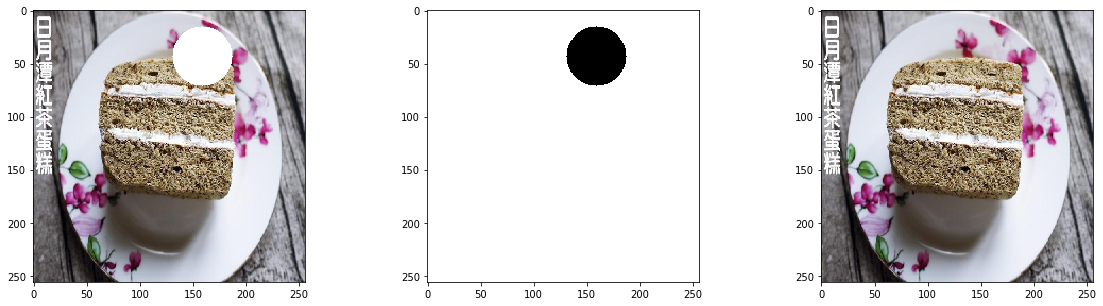

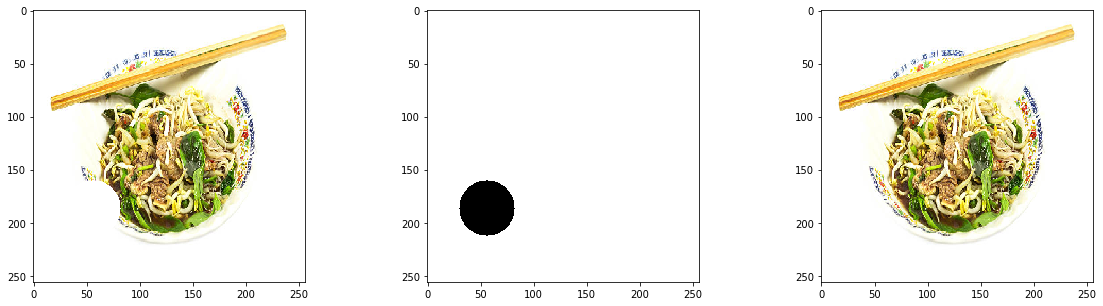

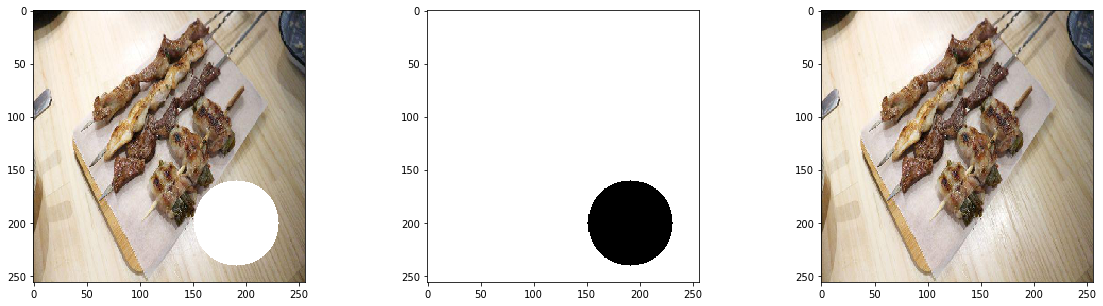

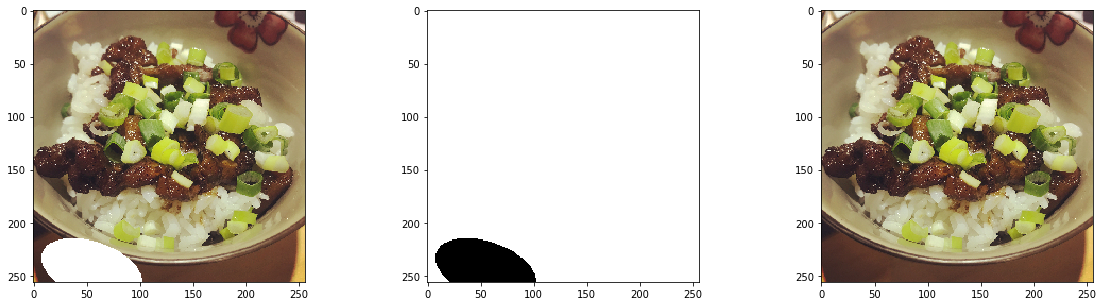

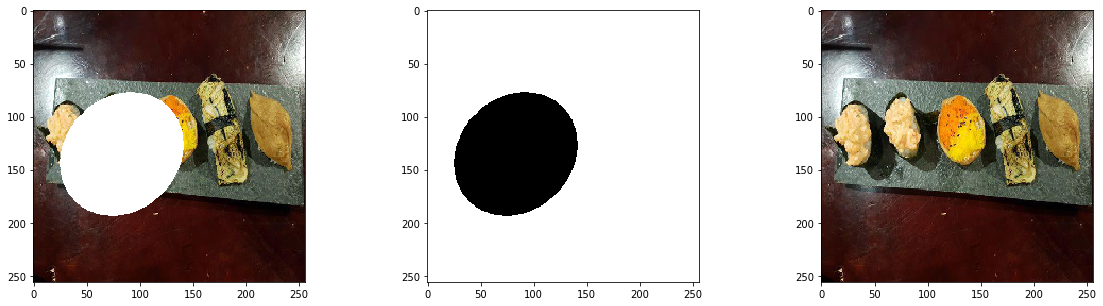

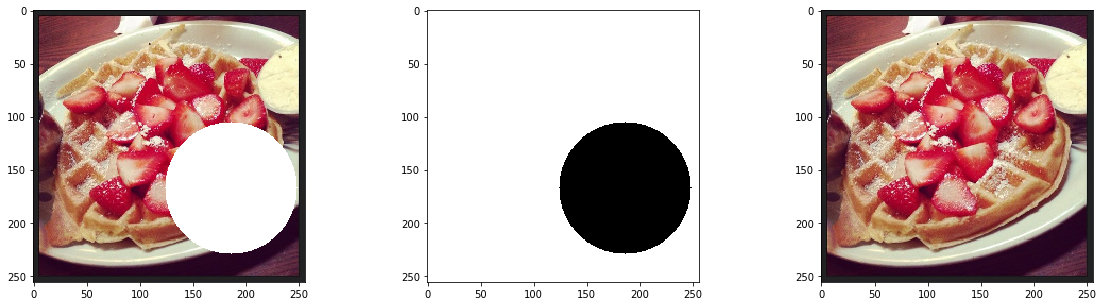

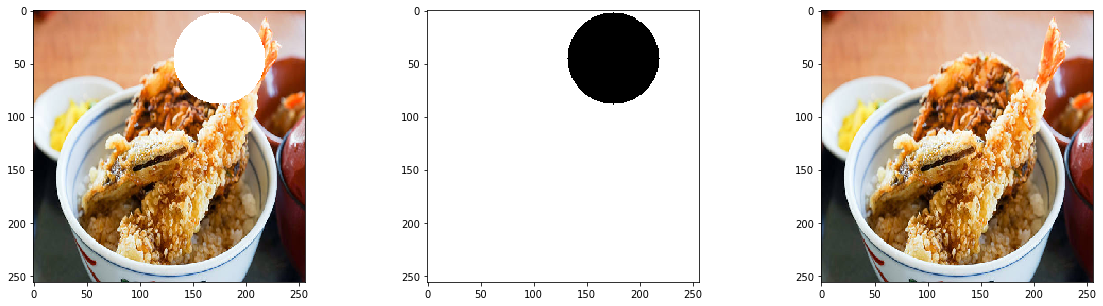

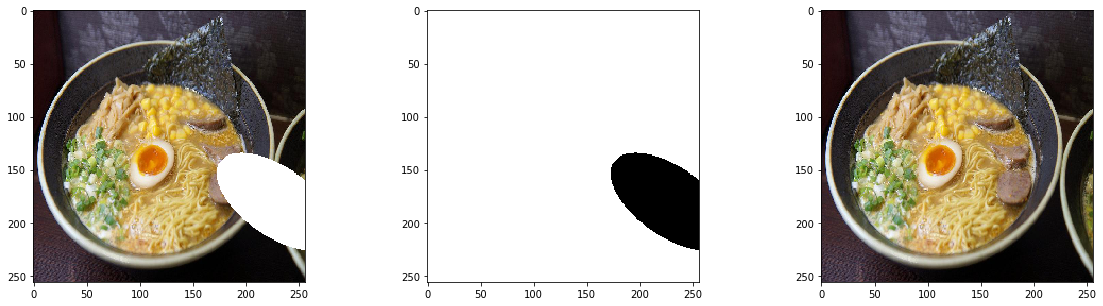

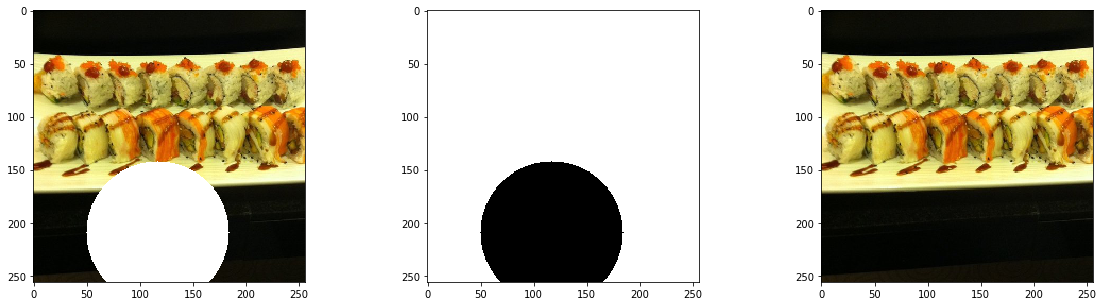

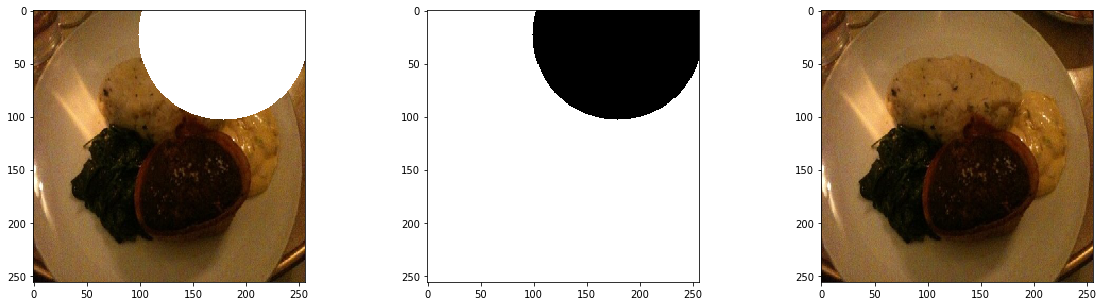

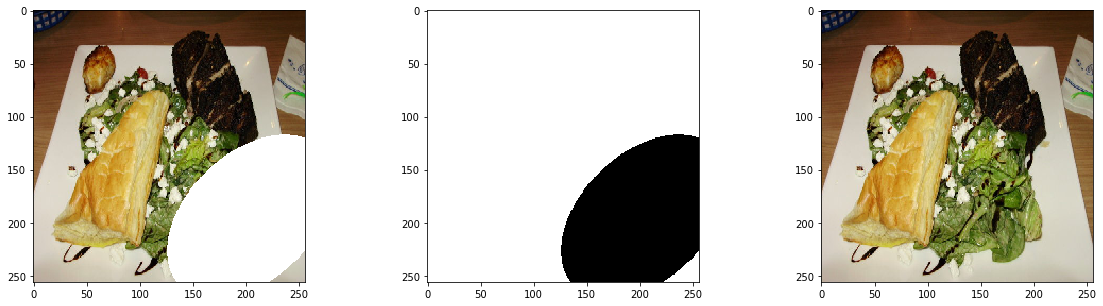

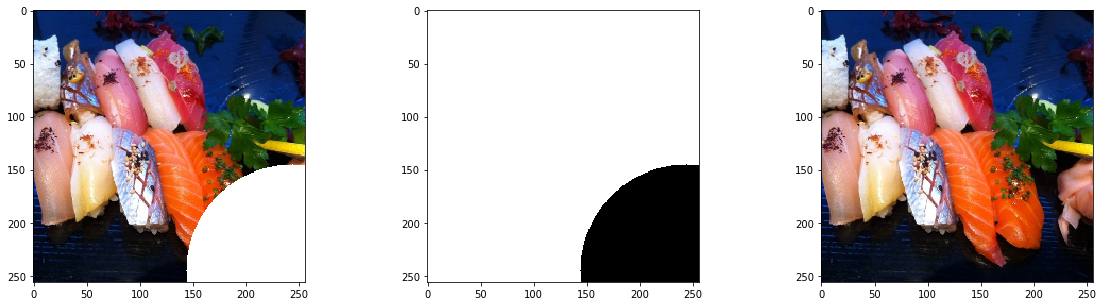

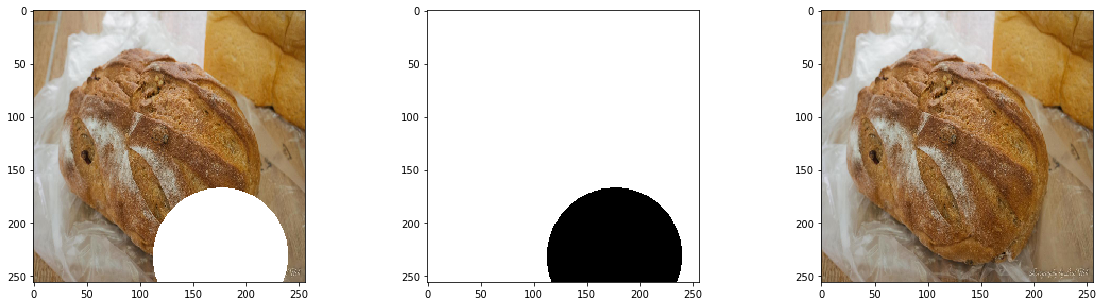

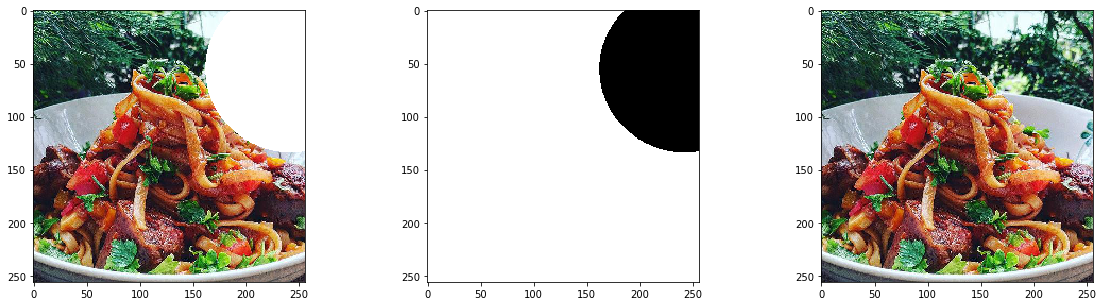

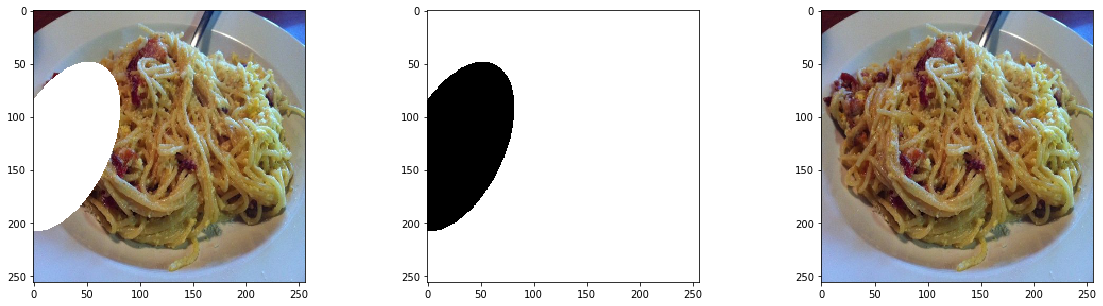

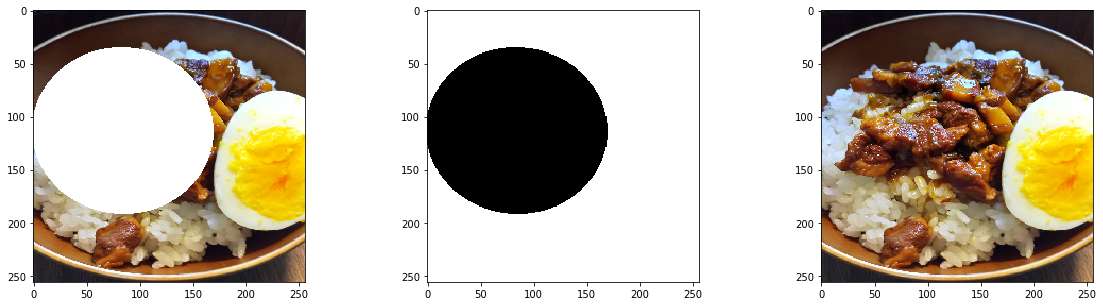

In [3]:
# Pick out an example
test_data = next(test_generator)
(masked, mask), ori = test_data

# Show side by side
for i in range(len(ori)):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[i,:,:,:])
    axes[1].imshow(mask[i,:,:,:] * 1.)
    axes[2].imshow(ori[i,:,:,:])
    plt.show()

# Training on ImageNet

In [4]:
def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')
                
        plt.savefig('/data/hackathon/PConv-Keras/data/test_xecp/img_{}.png'.format(pred_time))
        plt.close()

## Phase 1 - with batch normalization

In [5]:
# Instantiate the model
#pretrained = '/data/hackathon/PConv-Keras/data/logs_salad/46_weights_2018-08-15-23-53-12.h5'
#pretrained = '/data/hackathon/PConv-Keras/data/logs/62_weights_2018-08-16-15-34-43.h5'
pretrained = '/data/hackathon/PConv-Keras/data/logs_xcep/26_weights_2018-08-17-10-24-02.h5'
#weight_path = '/data/hackathon/PConv-Keras/data/logs_salad/'
#weight_path = '/data/hackathon/PConv-Keras/data/logs/'
weight_path = '/data/hackathon/PConv-Keras/data/logs_xcep/'

model = PConvUnet(weight_filepath=weight_path)
model.load(pretrained)

In [ ]:
# Run training for certain amount of epochs
model.fit(
    train_generator, 
    steps_per_epoch=2233,
    validation_data=val_generator,
    validation_steps=100,
    epochs=20,
    plot_callback=plot_callback,
    callbacks=[
        TensorBoard(log_dir=weight_path + 'initial_training', write_graph=False)
    ]
)

Epoch 27/27
Found 4488 images belonging to 20 classes.
Found 35738 images belonging to 20 classes.
1305/2233 [================>.............] - ETA: 8:08 - loss: 51378.4070

/home/jason/.local/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


2214/2233 [============================>.] - ETA: 9s - loss: 50758.3668 

## Phase 2 - without batch normalization

In [ ]:
# Load weights from previous run
model = PConvUnet(weight_filepath=weight_path)
model.load(
    pretrained,
    train_bn=False,
    lr=0.00005
)

In [ ]:
# Run training for certain amount of epochs
model.fit(
    train_generator, 
    steps_per_epoch=10000,
    validation_data=val_generator,
    validation_steps=100,
    epochs=20,        
    workers=3,
    plot_callback=plot_callback,
    callbacks=[
        TensorBoard(log_dir=weight_path + 'initial_training', write_graph=False)
    ]
)

## Phase 3 - Generating samples

In [ ]:
# Load weights from previous run
model = PConvUnet(weight_filepath=weight_path)
model.load(
    pretrained,
    train_bn=False,
    lr=0.00005
)

In [ ]:
n = 0
for (masked, mask), ori in tqdm(test_generator):
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    
    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[0].xaxis.set_major_formatter(NullFormatter())
        axes[0].yaxis.set_major_formatter(NullFormatter())
        axes[1].xaxis.set_major_formatter(NullFormatter())
        axes[1].yaxis.set_major_formatter(NullFormatter())
        
        plt.show()
        #plt.savefig('/data/hackathon/PConv-Keras/data/test_samples/img_{}_{}.png'.format(i, pred_time))
        #plt.close()
        n += 1
    # Only create predictions for about 100 images
    if n > 100:
        break

In [ ]:
import os
import numpy as np
import argparse
import warnings
import requests
from io import BytesIO
import base64
import attr
import skimage.io as ski_io
import skimage.color as ski_color
import skimage.morphology as ski_morph

@attr.s
class FoodQuiz:
    question_id = attr.ib()
    raw_image = attr.ib()
    bbox = attr.ib()
    description = attr.ib()


# 從 PIXNET 拿到比賽題目
def get_image(question_id, img_header=True):
    endpoint = 'http://pixnethackathon2018-competition.events.pixnet.net/api/question'
    payload = dict(question_id=question_id, img_header=img_header)
    print('Step 1: 從 PIXNET 拿比賽題目\n')
    response = requests.get(endpoint, params=payload)

    try:
        data = response.json()['data']
        question_id = data['question_id']
        description = data['desc']
        bbox = data['bounding_area']
        encoded_image = data['image']
        raw_image = ski_io.imread(
            BytesIO(base64.b64decode(encoded_image[encoded_image.find(',')+1:]))
        )

        header = encoded_image[:encoded_image.find(',')]
        if 'bmp' not in header:
            raise ValueError('Image should be BMP format')

        print('題號：', question_id)
        print('文字描述：', description)
        print('Bounding Box:', bbox)
        print('影像物件：', type(raw_image), raw_image.dtype, ', 影像大小：', raw_image.shape)

        quiz = FoodQuiz(question_id, raw_image, bbox, description)

    except Exception as err:
        # Catch exceptions here...
        print(data)
        raise err

    print('=====================')

    return quiz

# 上傳答案到 PIXNET
def submit_image(image, question_id):
    print('Step 3: 上傳答案到 PIXNET\n')

    endpoint = 'http://pixnethackathon2018-competition.events.pixnet.net/api/answer'

    #key = os.environ.get('PIXNET_FOODAI_KEY')
    key = 'nKGAB53gSyNsCBXV'

    # Assign image format
    image_format = 'jpeg'
    with BytesIO() as f:
        ski_io.imsave(f, image, format_str=image_format)
        f.seek(0)
        data = f.read()
        encoded_image = base64.b64encode(data)
    image_b64string = 'data:image/{};base64,'.format(image_format) + encoded_image.decode('utf-8')

    payload = dict(question_id=question_id,
                   key=key,
                   image=image_b64string)
    response = requests.post(endpoint, json=payload)
    try:
        rdata = response.json()
        if response.status_code == 200 and not rdata['error']:
            print('上傳成功')
        print('題號：', question_id)
        print('回答截止時間：', rdata['data']['expired_at'])
        print('所剩答題次數：', rdata['data']['remain_quota'])

    except Exception as err:
        print(rdata)
        raise err
    print('=====================')


parser = argparse.ArgumentParser(
    description='''
    PIXNET HACKATHON 競賽平台測試 0731 版.
    測試流程： `get_image` --> `inpainting` --> `submit_image`
    1. `get_image`: 取得測試題目，必須指定題目編號。
    2. `inpainting`: 參賽者的補圖邏輯實作在這一個 stage
    3. `submit_image`: 將補好的圖片與題號，提交回server，透過 PIXNET 核發的 API token 識別身份，故 token 請妥善保存。
    執行範例1：
        $ bash -c "export PIXNET_FOODAI_KEY=<YOUR-API-TOKEN>; python api_test_0731.py --qid 1"
    執行範例2:
        a. 將 API-TOKEN 如以下形式寫入某檔案，例如 .secrets.env 並存檔。
            export PIXNET_FOODAI_KEY=<YOUR-API-TOKEN>
        b. 執行:
        $ bash -c "source .secrets.env; python api_test_0731.py --qid 1"
    API 文件：https://github.com/pixnet/2018-pixnet-hackathon/blob/master/opendata/food.competition.api.md
    競賽平台位置：http://pixnethackathon2018-competition.events.pixnet.net/''',
    formatter_class=argparse.RawTextHelpFormatter
)
parser.add_argument('--qid', metavar='qid', nargs='?', type=int, default=1, help='題目編號(int)')


In [ ]:
# 使用你的模型，補全影像
def inpainting(quiz, debug=True):

    print('Step 2: 使用你的模型，補全影像\n')
    print('...')

    # Demo: mean-color inpainting
    raw_image = quiz.raw_image.copy()
    bbox = quiz.bbox
    mean_color = quiz.raw_image.mean(axis=(0, 1))  # shape: (3,)
    
    raw_roi = raw_image[bbox['y']:bbox['y']+bbox['h'], bbox['x']:bbox['x']+bbox['w'], :]
    mask = np.zeros(raw_image.shape[:2])
    mask_roi = mask[bbox['y']:bbox['y']+bbox['h'], bbox['x']:bbox['x']+bbox['w']]

    to_filling = (raw_roi[:, :, 1] == 255) & (raw_roi[:, :, 0] == 0) & (raw_roi[:, :, 2] == 0)
    mask_roi[to_filling] = 1
    
    mask = ski_morph.dilation(mask, ski_morph.square(7))
    mask = np.expand_dims(mask, axis=-1)
    
    mask = np.repeat(mask, 3, axis=2)
    mask = 1 - mask
    #ski_io.imshow(mask)
    
    masked = deepcopy(raw_image)
    masked[mask == 0] = 255
    masked = [x / 255.0 for x in masked]
    
    mask_p = np.expand_dims(mask, axis=0)
    masked_p = np.expand_dims(masked, axis=0)
    
    gen_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    gen_image = model.predict([masked_p, mask_p])
    

    if debug:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', category=UserWarning)
            _, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(masked)
            axes[1].imshow(gen_image[0,:,:,:])
            axes[0].set_title('Masked Image')
            axes[1].set_title('Predicted Image')
            axes[0].xaxis.set_major_formatter(NullFormatter())
            axes[0].yaxis.set_major_formatter(NullFormatter())
            axes[1].xaxis.set_major_formatter(NullFormatter())
            axes[1].yaxis.set_major_formatter(NullFormatter())
            plt.savefig('/data/hackathon/PConv-Keras/data/output/img_{}.png'.format(gen_time))
            plt.show()

    print('=====================')

    return gen_image[0,:,:,:]

In [ ]:
# Load weights from previous run

pretrained = '/data/hackathon/PConv-Keras/data/logs_salad/36_weights_2018-08-15-22-57-07.h5'
pretrained = '/data/hackathon/PConv-Keras/data/logs_sushi/35_weights_2018-08-15-18-46-27.h5'
pretrained = '/data/hackathon/PConv-Keras/data/logs_sashimi/35_weights_2018-08-15-18-46-27.h5'
pretrained = '/data/hackathon/PConv-Keras/data/logs/35_weights_2018-08-15-18-46-27.h5'

model = PConvUnet(weight_filepath=weight_path)
model.load(
    pretrained,
    train_bn=False,
    lr=0.00005
)

In [ ]:
#args = parser.parse_args()
quiz = get_image(10)
gen_image = inpainting(quiz)
submit_image(gen_image, quiz.question_id)
print('Done... Waiting for next round.')